In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [2]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])

    y = np.round(y)
    y = y.astype(int)
    
    ## Let's shift each signal so that reference time matches for each signal
    mean_ref_time = int(y.mean())
    X = np.array([signal_cyclic_shift(signal, mean_ref_time - y[i]) for i, signal in enumerate(X, 0)])
    y = np.array([mean_ref_time]*len(y))

    return X, y

def get_freq_data(X, freq=1, start_point=384):
    X_freq = np.concatenate([X[:, start_point::-freq][:, ::-1], X[:, start_point + freq::freq]], axis=1)
    return X_freq

def signal_cyclic_shift(signal, tau):
    signal_start = signal[:-tau]
    
    new_signal = np.concatenate([signal[-tau:], signal_start])
    
    return new_signal

In [3]:
X_origin, y_origin = get_data()

mean_argmin =  int(np.argmin(X_origin, axis=1).mean())

In [4]:
import random

def generate_multi_signal(X_origin, y_origin, tau, alpha, to_plot=False):
    first_idx, second_idx = np.random.choice(X_origin.shape[0], 2, replace=False)
    first_impulse = X_origin[first_idx]
    second_impulse = X_origin[second_idx]
    
    first_ref_time = y_origin[first_idx]
    second_ref_time = y_origin[second_idx]
    
    
#     print("SHIFT:", tau)
#     print("BEFORE SHIFT:", first_ref_time, second_ref_time)
    ### Randomly choose what signal to shift
    if random.choice([True, False]):
        first_impulse = signal_cyclic_shift(first_impulse, tau)
        first_ref_time += tau
    else:
        second_impulse = signal_cyclic_shift(second_impulse, tau)
        second_ref_time += tau
    
#     print("AFTER SHIFT:", first_ref_time, second_ref_time)

    
    multi_impulse = first_impulse + second_impulse*alpha
    multi_impulse /= -np.min(multi_impulse)
    
    first_impulse_shifted = signal_cyclic_shift(first_impulse, mean_argmin - np.argmin(first_impulse))
    second_impulse_shifted = signal_cyclic_shift(second_impulse, mean_argmin - np.argmin(second_impulse))
    multi_impulse_shifted = signal_cyclic_shift(multi_impulse, mean_argmin - np.argmin(multi_impulse))

#     print(mean_argmin - np.argmin(multi_impulse))
    first_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    second_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    
    if to_plot:
        plt.plot(first_impulse)
        plt.plot(second_impulse)
        plt.plot(multi_impulse_shifted)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
        
        
    if alpha > 1:                   ### If we have alpha >= 1 so second_ref_time always will be close to 167
        ref_time = first_ref_time   ### so we will predict first_ref_time 
    else:
        ref_time = second_ref_time
        
    ref_time = first_ref_time
        
    return {'first_impulse': first_impulse_shifted,\
            'second_impulse': second_impulse_shifted,\
            'ref_time': ref_time,\
            'multi_impulse': multi_impulse_shifted}

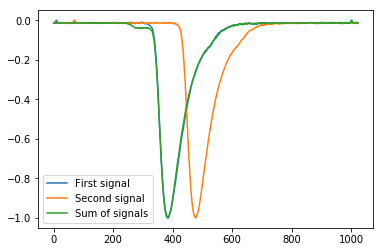

In [5]:
alpha_range = np.arange(1, 100, 0.1)
tau_range = np.arange(-100, 101, 1)

alpha = random.choice(alpha_range)
tau = random.choice(tau_range)
signal = generate_multi_signal(X_origin, y_origin, tau, alpha, to_plot=True)

In [6]:
signal

{'first_impulse': array([-0.01194479, -0.01372096, -0.01392395, ..., -0.01117722,
        -0.01236346, -0.01156418]),
 'second_impulse': array([-0.01506391, -0.01568815, -0.01351275, ..., -0.0119742 ,
        -0.0131218 , -0.0143766 ]),
 'ref_time': 73,
 'multi_impulse': array([-0.01534752, -0.01595161, -0.01380755, ..., -0.01226635,
        -0.01345279, -0.01468183])}

In [7]:
from sklearn.utils import shuffle

def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha)
        
        
        X.append(signal['multi_impulse'])
        y.append(signal['ref_time']) 
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [8]:
# alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.01)])

# alpha_range = [10]
# tau_range = [0]
alpha_range = np.arange(1, 100, 0.1)
tau_range = np.arange(-100, 101, 1)

In [9]:
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=5000, to_print=True) 

X shape: (5000, 1024)
y shape: (5000,)


In [10]:
from sklearn.preprocessing import normalize

(array([472., 481., 512., 546., 514., 568., 486., 458., 482., 481.]),
 array([ 64. ,  84.4, 104.8, 125.2, 145.6, 166. , 186.4, 206.8, 227.2,
        247.6, 268. ]),
 <a list of 10 Patch objects>)

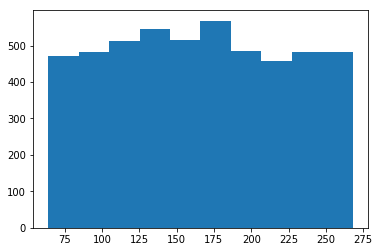

In [11]:
plt.hist(y)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [13]:
def print_scores():
    for model in models.values():    
        model_name = type(model).__name__
        print("Regressor:", model_name)
    #         stregr = StackingRegressor(regressors=models, meta_regressor=model)
        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, scoring=scoring, cv=5)

        r2_score_mean = scores['test_r2'].mean()
        r2_score_std = scores['test_r2'].std()
        mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
        mse_score_std = scores['test_neg_mean_squared_error'].std()
        mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
        mae_score_std = scores['test_neg_mean_absolute_error'].std()
        rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
        rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

        cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                          (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
        print("95% confidence interval:")
        for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
            print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
        print('----------------------------------')
    print('____________________________________________________________')
    print()

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
def get_models():
    huber_reg = HuberRegressor(epsilon= 6.82, alpha= 0.01)
    ridge_reg = linear_model.Ridge(solver='saga', max_iter=5000, alpha= 1)
    lasso_reg = linear_model.Lasso(max_iter=4400, alpha=0.3, normalize=False)
    dt_reg = tree.DecisionTreeRegressor(min_samples_split=7, min_samples_leaf=9, min_weight_fraction_leaf=0.1, 
                                                                                                 max_features='sqrt')

    pa_reg = PassiveAggressiveRegressor(C=0.44, max_iter=2800, tol=2.4e-5)
    xgb_reg = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)
    return {'huber': huber_reg, 'ridge': ridge_reg, 'lasso': lasso_reg, 'dt': dt_reg, 'pa':pa_reg, 'xgb': xgb_reg}

In [16]:
models = get_models()

In [17]:
print_scores()

Regressor: HuberRegressor
95% confidence interval:
r2 score: 0.23917 (+/- 0.03805)
mse score: 2522.08268 (+/- 152.67997)
mae score: 41.08018 (+/- 1.26749)
rmse score: 50.21449 (+/- 1.53261)
----------------------------------
Regressor: Ridge
95% confidence interval:
r2 score: 0.24222 (+/- 0.03571)
mse score: 2512.05909 (+/- 151.72258)
mae score: 41.07622 (+/- 1.36207)
rmse score: 50.11465 (+/- 1.52384)
----------------------------------
Regressor: Lasso
95% confidence interval:
r2 score: 0.19327 (+/- 0.01936)
mse score: 2674.50710 (+/- 135.37409)
mae score: 43.98066 (+/- 1.18474)
rmse score: 51.71149 (+/- 1.30929)
----------------------------------
Regressor: DecisionTreeRegressor
95% confidence interval:
r2 score: 0.74520 (+/- 0.06176)
mse score: 843.71119 (+/- 189.55938)
mae score: 21.13450 (+/- 2.25529)
rmse score: 29.00205 (+/- 3.21999)
----------------------------------
Regressor: PassiveAggressiveRegressor
95% confidence interval:
r2 score: -0.25407 (+/- 0.78860)
mse score: 4166.

### Stacking

In [18]:
from mlxtend.regressor import StackingRegressor


In [19]:
for i in range(len(models)):
    models = get_models()
    del models['pa'] ### Delete passive agressive regressor, which performs poorly
    
    print("Metaregressor:", type(models[i]).__name__)

    stregr = StackingRegressor(regressors=models, meta_regressor=models[i])
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(stregr, X, y, scoring=scoring, cv=5)

    r2_score_mean = scores['test_r2'].mean()
    r2_score_std = scores['test_r2'].std()
    mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
    mse_score_std = scores['test_neg_mean_squared_error'].std()
    mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
    mae_score_std = scores['test_neg_mean_absolute_error'].std()
    rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
    rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

    cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                      (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
    print("95% confidence interval:")
    for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
        print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
    print('--------------------------------------------------------')

KeyError: 0

### Let's plot regression scores for different frequency, tau and alpha values

In [20]:
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error

In [21]:
alpha_values = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_values = range(-200, 210, 10)
freq_values = [1, 25, 50, 60, 75, 85, 100]
# alpha_values = np.around(np.arange(0, 100, 2), decimals=2)

In [22]:
def calculate_scores(X_origin, y_orign, alpha_values, tau_values, data_size=100, freq=1):
#     NORM_COEF = 50
    scores_dict = {}
    
    
    X, y = prepare_data(X_origin, y_origin, tau_values, alpha_values, to_print=False, data_size=len(X_origin))
    model = models['dt']
    X_freq = get_freq_data(X, freq=freq)
    model.fit(X_freq, y)

    
    for tau in tqdm.tqdm(tau_values):
        scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))
        for alpha in alpha_values:
            X_cur, y_cur = prepare_data(X_freq, y_origin, [tau], [alpha], data_size=data_size)
            y_pred = model.predict(X_cur)

            scores_dict[tau][alpha] = mean_absolute_error(y_pred, y_cur)
    return scores_dict

In [23]:
def dict_to_arrays(scores_dict):
    x, y, z = [], [], []
    for tau, alpha_dict in scores_dict.items():
        for alpha, score in alpha_dict.items():
            x.append(tau)
            y.append(alpha)
            z.append(score)
            
    return [x, y, z]

In [24]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_color_map(scores_dict, alpha_values, tau_values, alpha_freq=10, tau_freq=4, freq=1):
    _, _, z = dict_to_arrays(scores_dict)
    z = np.array(z)
    Z = z.reshape((len(tau_values), len(alpha_values)))

    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.title("MAE, freq = " + str(freq))
    plt.xlabel("Two signals ratio", fontsize=12)
    plt.ylabel("Delta t [ns]", fontsize=12)
    plt.xticks([alpha_freq*i for i in range(len(alpha_values[::alpha_freq]))], alpha_values[::alpha_freq])
    plt.yticks([tau_freq*i for i in range(len(tau_values[::tau_freq]))], [0.2*el for el in tau_values[::tau_freq]])

    im = ax.imshow(Z, interpolation='bilinear', cmap='spring', aspect='auto')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    plt.colorbar(im, cax=cax)
    plt.show()

100%|██████████| 41/41 [05:19<00:00,  7.78s/it]


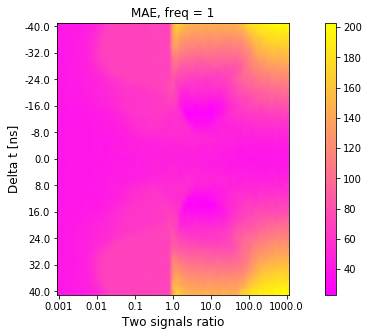

100%|██████████| 41/41 [04:53<00:00,  7.16s/it]


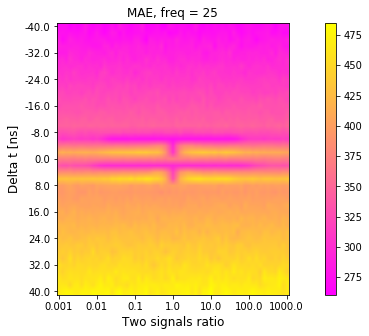

100%|██████████| 41/41 [57:30<00:00, 84.16s/it]


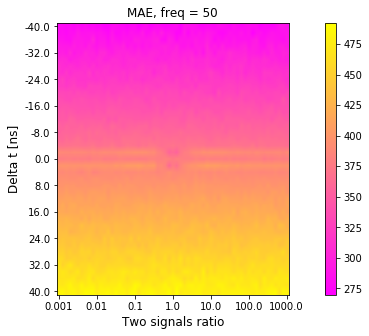

 61%|██████    | 25/41 [2:02:23<1:18:19, 293.73s/it]

In [ ]:
for freq in freq_values:
    X_origin, y_origin = get_data()
    scores_dict = calculate_scores(X_origin, y_origin, alpha_values, tau_values, data_size=500, freq=freq)
    plot_color_map(scores_dict, alpha_values, tau_values, freq=freq)
    save_obj(scores_dict, 'scores_ref_time_freq=' + str(freq))
#     plot_score_3d(scores_dict)